In [27]:
import torch
from torch_geometric.nn import GCNConv
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.data import Data
import numpy as np

In [48]:
class TemporalGraphAutoencoder(nn.Module):
    def __init__(self, num_nodes, hidden_dim, embedding_dim, num_time_steps, batch_size):
        super(TemporalGraphAutoencoder, self).__init__()
        self.num_time_steps = num_time_steps
        self.num_nodes = num_nodes
        self.batch_size = batch_size
        self.encoder = GCNConv(num_nodes, hidden_dim)
        self.embedding_layer = GCNConv(hidden_dim, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim * num_nodes, hidden_dim, batch_first=True)
        self.decoder = nn.Linear(hidden_dim, num_nodes * num_nodes)

    def forward(self, data_list):
        encoded_graphs = []

        for data in data_list:
            x, edge_index = data.x, data.edge_index
            x = F.relu(self.encoder(x, edge_index))
            x_embedding = self.embedding_layer(x, edge_index)
            encoded_graphs.append(x_embedding.view(self.batch_size, -1))

        # Shape: [batch_size, num_time_steps, embedding_dim * num_nodes]
        encoded_sequence = torch.stack(encoded_graphs, dim=1)
        lstm_output, _ = self.lstm(encoded_sequence)
        # Decode each time step
        reconstructed_all_steps = []
        for t in range(self.num_time_steps):
            x_reconstructed = self.decoder(lstm_output[:, t, :])
            reconstructed_all_steps.append(x_reconstructed.view(self.batch_size, self.num_nodes, self.num_nodes))

        # Stack to get the final output tensor of shape [batch_size, num_time_steps, num_nodes, num_nodes]
        reconstructed_all_steps = torch.stack(reconstructed_all_steps, dim=1)
        return reconstructed_all_steps
    
def loss_function(reconstructed, original):
    # Compute loss across all time steps
    return F.mse_loss(reconstructed, original)

In [10]:
dataset_input = torch.load('/home/matteoc/graphs-nn/data/dataset_input.pt')
dataset_ground = torch.load('/home/matteoc/graphs-nn/data/dataset_ground.pt')

print('x_split shape (data splitted into time windows): ', dataset_input[0].shape)
print('fc_matrices_dgbsl shape (final graph): ', dataset_ground[0].shape)

x_split shape (data splitted into time windows):  torch.Size([1, 39, 360, 30])
fc_matrices_dgbsl shape (final graph):  torch.Size([1, 39, 360, 360])


In [44]:
import networkx as nx

def threshold_fc_matrix(fc_matrix, percentile=5):
    """
    Threshold the FC matrix to keep only the top percentile connections.
    """
    fc_matrix = fc_matrix.detach().numpy()
    threshold = np.percentile(fc_matrix[np.tril_indices_from(fc_matrix, k=-1)], 100 - percentile)   
    graph = (fc_matrix > threshold).astype(int)
    np.fill_diagonal(graph, 0)  # remove self-edges
    return graph

def convert_to_pyg_graph(nx_graph):
    graph = nx.Graph(nx_graph)
    edges = torch.tensor(list(graph.edges), dtype=torch.long).t().contiguous()
    x = torch.tensor(np.identity(graph.number_of_nodes()), dtype=torch.float)
    
    # For unsupervised learning, you typically don't have node labels
    # If you have node features, replace x with them
    return Data(x=x, edge_index=edges)


adj_matrix = dataset_ground[0][0]
num_time_steps = adj_matrix.shape[0]
num_nodes = adj_matrix.shape[1]
hidden_dim = 64
embedding_dim = 32
batch_size = 1  # Can be changed as needed

# Convert each time slice to a graph
tensor_list = torch.unbind(adj_matrix, dim=0)
graphs = [threshold_fc_matrix(fc) for fc in tensor_list] 
pyg_graphs = [convert_to_pyg_graph(g) for g in graphs]


In [31]:
pyg_graphs

[Data(x=[360, 360], edge_index=[2, 3231]),
 Data(x=[360, 360], edge_index=[2, 3231]),
 Data(x=[360, 360], edge_index=[2, 3231]),
 Data(x=[360, 360], edge_index=[2, 3231]),
 Data(x=[360, 360], edge_index=[2, 3231]),
 Data(x=[360, 360], edge_index=[2, 3231]),
 Data(x=[360, 360], edge_index=[2, 3231]),
 Data(x=[360, 360], edge_index=[2, 3231]),
 Data(x=[360, 360], edge_index=[2, 3231]),
 Data(x=[360, 360], edge_index=[2, 3231]),
 Data(x=[360, 360], edge_index=[2, 3231]),
 Data(x=[360, 360], edge_index=[2, 3231]),
 Data(x=[360, 360], edge_index=[2, 3231]),
 Data(x=[360, 360], edge_index=[2, 3231]),
 Data(x=[360, 360], edge_index=[2, 3231]),
 Data(x=[360, 360], edge_index=[2, 3231]),
 Data(x=[360, 360], edge_index=[2, 3231]),
 Data(x=[360, 360], edge_index=[2, 3231]),
 Data(x=[360, 360], edge_index=[2, 3231]),
 Data(x=[360, 360], edge_index=[2, 3231]),
 Data(x=[360, 360], edge_index=[2, 3231]),
 Data(x=[360, 360], edge_index=[2, 3231]),
 Data(x=[360, 360], edge_index=[2, 3231]),
 Data(x=[36

In [49]:
model = TemporalGraphAutoencoder(num_nodes, hidden_dim, embedding_dim, num_time_steps, batch_size)


In [50]:
from tqdm import trange

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()
epochs = trange(50)
for epoch in epochs:
    optimizer.zero_grad()
    reconstructed = model(pyg_graphs)
    loss = loss_function(reconstructed, adj_matrix)
    loss.backward()
    optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

  0%|          | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_816297/4137449674.py:36: UserWarning: Using a target size (torch.Size([39, 360, 360])) that is different to the input size (torch.Size([1, 39, 360, 360])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(reconstructed, original)
  2%|▏         | 2/100 [00:00<00:22,  4.42it/s]

Epoch 1, Loss: 0.44136202335357666
Epoch 2, Loss: 0.43013864755630493


  3%|▎         | 3/100 [00:00<00:21,  4.45it/s]

Epoch 3, Loss: 0.3792918920516968


  5%|▌         | 5/100 [00:01<00:20,  4.71it/s]

Epoch 4, Loss: 0.26352405548095703
Epoch 5, Loss: 0.21721091866493225


  6%|▌         | 6/100 [00:01<00:19,  4.77it/s]

Epoch 6, Loss: 0.17399252951145172


  7%|▋         | 7/100 [00:01<00:19,  4.77it/s]

Epoch 7, Loss: 0.13542146980762482


  9%|▉         | 9/100 [00:01<00:19,  4.66it/s]

Epoch 8, Loss: 0.10298275947570801
Epoch 9, Loss: 0.07715048640966415


 10%|█         | 10/100 [00:02<00:18,  4.82it/s]

Epoch 10, Loss: 0.05774484947323799


 11%|█         | 11/100 [00:02<00:19,  4.59it/s]

Epoch 11, Loss: 0.0441453792154789


 12%|█▏        | 12/100 [00:02<00:19,  4.44it/s]

Epoch 12, Loss: 0.03545810654759407


 14%|█▍        | 14/100 [00:03<00:17,  4.84it/s]

Epoch 13, Loss: 0.030660167336463928
Epoch 14, Loss: 0.02871870994567871


 16%|█▌        | 16/100 [00:03<00:15,  5.53it/s]

Epoch 15, Loss: 0.02867952547967434
Epoch 16, Loss: 0.02972499281167984


 18%|█▊        | 18/100 [00:03<00:13,  6.22it/s]

Epoch 17, Loss: 0.031204260885715485
Epoch 18, Loss: 0.03264063969254494


 20%|██        | 20/100 [00:03<00:11,  6.67it/s]

Epoch 19, Loss: 0.03372211754322052
Epoch 20, Loss: 0.03428047522902489


 22%|██▏       | 22/100 [00:04<00:11,  6.80it/s]

Epoch 21, Loss: 0.03426367789506912
Epoch 22, Loss: 0.0337054580450058


 24%|██▍       | 24/100 [00:04<00:10,  7.02it/s]

Epoch 23, Loss: 0.032695382833480835
Epoch 24, Loss: 0.03135223686695099


 26%|██▌       | 26/100 [00:04<00:10,  7.01it/s]

Epoch 25, Loss: 0.029802514240145683
Epoch 26, Loss: 0.028164859861135483


 28%|██▊       | 28/100 [00:05<00:10,  7.14it/s]

Epoch 27, Loss: 0.026540186256170273
Epoch 28, Loss: 0.02500670775771141


 30%|███       | 30/100 [00:05<00:09,  7.17it/s]

Epoch 29, Loss: 0.023618588224053383
Epoch 30, Loss: 0.022407248616218567


 32%|███▏      | 32/100 [00:05<00:09,  7.22it/s]

Epoch 31, Loss: 0.02138429880142212
Epoch 32, Loss: 0.020545465871691704


 34%|███▍      | 34/100 [00:05<00:09,  7.25it/s]

Epoch 33, Loss: 0.01987496390938759
Epoch 34, Loss: 0.019349804148077965


 36%|███▌      | 36/100 [00:06<00:08,  7.29it/s]

Epoch 35, Loss: 0.018943648785352707
Epoch 36, Loss: 0.018629923462867737


 38%|███▊      | 38/100 [00:06<00:08,  7.27it/s]

Epoch 37, Loss: 0.018384026363492012
Epoch 38, Loss: 0.018184728920459747


 40%|████      | 40/100 [00:06<00:08,  7.29it/s]

Epoch 39, Loss: 0.018014846369624138
Epoch 40, Loss: 0.017861420288681984


 42%|████▏     | 42/100 [00:06<00:08,  7.25it/s]

Epoch 41, Loss: 0.01771555095911026
Epoch 42, Loss: 0.017571933567523956


 44%|████▍     | 44/100 [00:07<00:07,  7.20it/s]

Epoch 43, Loss: 0.017428243532776833
Epoch 44, Loss: 0.017284367233514786


 46%|████▌     | 46/100 [00:07<00:07,  7.09it/s]

Epoch 45, Loss: 0.01714162342250347
Epoch 46, Loss: 0.017002057284116745


 48%|████▊     | 48/100 [00:07<00:07,  7.12it/s]

Epoch 47, Loss: 0.01686786487698555
Epoch 48, Loss: 0.01674102246761322


 50%|█████     | 50/100 [00:08<00:06,  7.34it/s]

Epoch 49, Loss: 0.01662306860089302
Epoch 50, Loss: 0.016515012830495834


 52%|█████▏    | 52/100 [00:08<00:06,  7.32it/s]

Epoch 51, Loss: 0.01641734689474106
Epoch 52, Loss: 0.01633007824420929


 54%|█████▍    | 54/100 [00:08<00:06,  7.23it/s]

Epoch 53, Loss: 0.01625281572341919
Epoch 54, Loss: 0.01618485525250435


 56%|█████▌    | 56/100 [00:08<00:06,  7.33it/s]

Epoch 55, Loss: 0.01612529717385769
Epoch 56, Loss: 0.01607314683496952


 58%|█████▊    | 58/100 [00:09<00:05,  7.37it/s]

Epoch 57, Loss: 0.016027400270104408
Epoch 58, Loss: 0.015987111255526543


 60%|██████    | 60/100 [00:09<00:05,  7.33it/s]

Epoch 59, Loss: 0.01595141924917698
Epoch 60, Loss: 0.015919584780931473


 62%|██████▏   | 62/100 [00:09<00:05,  7.39it/s]

Epoch 61, Loss: 0.01589098758995533
Epoch 62, Loss: 0.01586512103676796


 64%|██████▍   | 64/100 [00:09<00:04,  7.38it/s]

Epoch 63, Loss: 0.015841595828533173
Epoch 64, Loss: 0.015820099040865898


 66%|██████▌   | 66/100 [00:10<00:04,  7.42it/s]

Epoch 65, Loss: 0.01580039970576763
Epoch 66, Loss: 0.015782317146658897


 68%|██████▊   | 68/100 [00:10<00:04,  7.49it/s]

Epoch 67, Loss: 0.015765709802508354
Epoch 68, Loss: 0.015750471502542496


 70%|███████   | 70/100 [00:10<00:04,  6.77it/s]

Epoch 69, Loss: 0.015736518427729607
Epoch 70, Loss: 0.015723779797554016


 72%|███████▏  | 72/100 [00:11<00:04,  6.41it/s]

Epoch 71, Loss: 0.015712203457951546
Epoch 72, Loss: 0.01570172607898712


 74%|███████▍  | 74/100 [00:11<00:03,  6.75it/s]

Epoch 73, Loss: 0.01569228246808052
Epoch 74, Loss: 0.015683792531490326


 76%|███████▌  | 76/100 [00:11<00:03,  7.01it/s]

Epoch 75, Loss: 0.01567617431282997
Epoch 76, Loss: 0.015669330954551697


 78%|███████▊  | 78/100 [00:11<00:03,  7.33it/s]

Epoch 77, Loss: 0.01566317491233349
Epoch 78, Loss: 0.015657620504498482


 80%|████████  | 80/100 [00:12<00:02,  7.31it/s]

Epoch 79, Loss: 0.015652591362595558
Epoch 80, Loss: 0.01564803160727024


 82%|████████▏ | 82/100 [00:12<00:02,  7.30it/s]

Epoch 81, Loss: 0.015643885359168053
Epoch 82, Loss: 0.015640124678611755


 84%|████████▍ | 84/100 [00:12<00:02,  7.48it/s]

Epoch 83, Loss: 0.015636714175343513
Epoch 84, Loss: 0.015633629634976387


 86%|████████▌ | 86/100 [00:13<00:01,  7.40it/s]

Epoch 85, Loss: 0.015630844980478287
Epoch 86, Loss: 0.015628337860107422


 88%|████████▊ | 88/100 [00:13<00:01,  7.32it/s]

Epoch 87, Loss: 0.015626078471541405
Epoch 88, Loss: 0.015624037012457848


 90%|█████████ | 90/100 [00:13<00:01,  7.31it/s]

Epoch 89, Loss: 0.015622188337147236
Epoch 90, Loss: 0.015620503574609756


 92%|█████████▏| 92/100 [00:13<00:01,  7.29it/s]

Epoch 91, Loss: 0.015618962235748768
Epoch 92, Loss: 0.015617543831467628


 94%|█████████▍| 94/100 [00:14<00:00,  7.31it/s]

Epoch 93, Loss: 0.015616240911185741
Epoch 94, Loss: 0.01561504602432251


 96%|█████████▌| 96/100 [00:14<00:00,  7.35it/s]

Epoch 95, Loss: 0.015613947995007038
Epoch 96, Loss: 0.015612948685884476


 98%|█████████▊| 98/100 [00:14<00:00,  7.42it/s]

Epoch 97, Loss: 0.015612035058438778
Epoch 98, Loss: 0.015611198730766773


100%|██████████| 100/100 [00:14<00:00,  6.68it/s]

Epoch 99, Loss: 0.015610439702868462
Epoch 100, Loss: 0.015609745867550373


In [53]:
reconstructed_graph = [threshold_fc_matrix(fc) for fc in reconstructed[0]] 

In [58]:
len(reconstructed_graph)

39

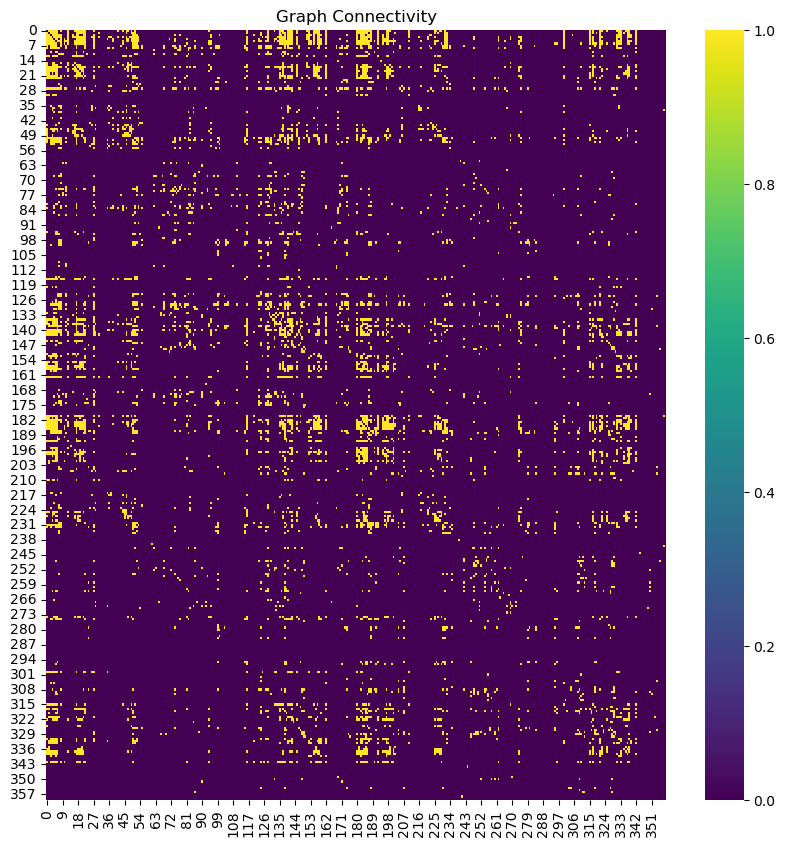

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 10))
sns.heatmap(reconstructed_graph[0], cmap='viridis')
plt.title('Graph Connectivity')
plt.show()